# Surface classification using 2-forms

In this notebook we show how to integrate $2$- forms in $\mathbb{R}^n$ over the $2$-simplices of a complex and use this method to classify surfaces in $\mathbb{R}^3$

### Theory 

A $2$-form in $\mathbb{R}^n$, denoted by $\omega \in \Omega^2(\mathbb{R}^n)$ can be written as $$\omega = \sum_{1\leq i < j \leq n} f_{i,j} dx_i\wedge dx_j$$
where $f_{i,j}: \mathbb{R}^n\longrightarrow \mathbb{R}^N$, with $N = \binom{n}{2} $ are smooth maps. 

**remark 1:** this means that we can train a neural network $\mathbb{R}^n \longrightarrow \mathbb{R}^N$ to learn $2$-forms on $\mathbb{R}^n$.

##### Integrating a $2$-form on a 2-simplex:
Denote by $\Delta$ the standard $2$-simplex in $\mathbb{R}^2$ with vertices $(0,0), (1,0), (0,1)$.
A $2$-simplex $\sigma$ in $\mathbb{R}^n$ is obtained as the embedding of $\Delta$ via a map $\varphi: \Delta \longrightarrow \mathbb{R}^n$, $\sigma = \varphi(\Delta)$. Thus to integrate the $2$-form $\omega$ on $\sigma$ one can use the identity: 
$$ \int_{\varphi(\Delta)}\omega = \int_{\Delta}\varphi^{*}\omega$$

To obtain a $2$-cochain on an embedded simplicial complex, one integrates the $2$-form on each $2$-simplex. 


**remark 2:** In more generality one can learn any $k$-form on $\mathbb{R}^n$ and integrate it on a $k$-simplex.   

### Algorithmically : 

To compute the integral on a simplex one must make an approximation in the following way. 
1. subdivide $\Delta$ into $m^2$ $2$-simplices $\mathcal{S} = \{s_l\}_{0\leq l \leq m^2}$ of equal area 
2. Denote by $V$ the set of vertices in the subdivision of $\Delta$
3. For any $p\in \Delta$ one can evaluate $\omega$ at that point and get a map $g: \Delta \rightarrow \mathbb{R}$ in the following way:
$$ g(p) = \sum_{i<j} f_{i,j}(\varphi(p))dx_i\wedge dx_j (\varphi_{*}\frac{\partial}{\partial y_1}\mid_p,\varphi_{*}\frac{\partial}{\partial y_2}\mid_p)$$
4. In particular to approximate the contribution of a $2$-simplex $s\in\mathcal{S}$ to the integral one averages the value of $g(p)$ on each of its vertices $p$. Overall each vertex will contribute with weight
    - 1 if $p\in\{(0,0),(1,0),(0,1)\}$
    - 3 if $p$ is in the interior of an edge of $\Delta$
    - 6 if $p$ is in the interior of $\Delta$

    to the approximating sum below : 
5. By reordering the terms we get the following expression for the integral 
$$ \int_{\varphi(\Delta)} \omega = \frac{1}{m^2} \sum_{p\in V} |cof(p)|\cdot g(p) \cdot vol(\varphi(\Delta))$$ 


To compute $$dx_i\wedge dx_j (\varphi_{*}\frac{\partial}{\partial y_1}\mid_p,\varphi_{*}\frac{\partial}{\partial y_2}\mid_p)$$
one does the following: 


<span style="color: red;">  FILLLL </span>



## Tasks: 

2. run for longer and make plots of accuracy


In [138]:
import numpy as np
import matplotlib as mpl
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import gudhi as gd 
import scipy.special
import pickle

from sklearn.decomposition import PCA
import pandas as pd

import k_forms as kf
import k_forms_visual as vis   

import torch.optim as optim

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Creating the synthetic data set of surfaces 

The random surfaces in this notebook are created by embedding a triangulation of the unit square $[0,1]\times [0,1]$ in $\mathbb{R}^3$. 
We subdivide the interval $[0,1]$ in <code>num_pts</code> points to obtain a grid of vertices in the unit square and take the alpha complex of those vertices.

The 2-simplices are:  [[0, 1, 5], [1, 2, 6], [1, 5, 6], [2, 3, 7], [2, 6, 7], [3, 4, 8], [3, 7, 8], [4, 8, 9], [5, 6, 10], [6, 7, 11], [6, 10, 11], [7, 8, 12], [7, 11, 12], [8, 9, 13], [8, 12, 13], [9, 13, 14], [10, 11, 15], [11, 12, 16], [11, 15, 16], [12, 13, 17], [12, 16, 17], [13, 14, 18], [13, 17, 18], [14, 18, 19], [15, 16, 20], [16, 17, 21], [16, 20, 21], [17, 18, 22], [17, 21, 22], [18, 19, 23], [18, 22, 23], [19, 23, 24]]
There are  32  2-simplices


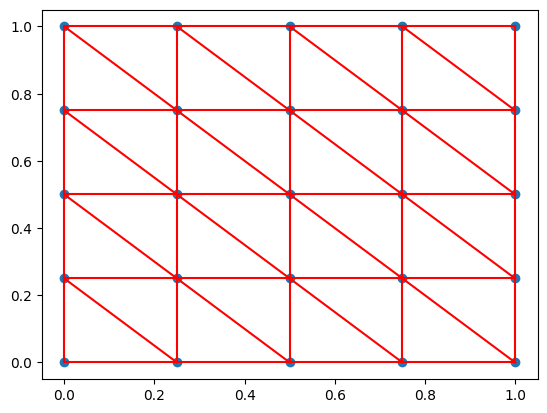

In [139]:
num_pts = 5 ##number of points to subddivide the intverval [0,1] into 

# create and plot an alpha-complex on the unit square 
pts , ac = kf.plot_unit_square_grid(num_pts)

simplices = [] #list of 2-simplices 
for s in ac.get_skeleton(2):
    if len(s[0]) == 3: 
        simplices.append(s[0])

print("The 2-simplices are: ", simplices)
print("There are ", len(simplices), " 2-simplices")

#### 1.1 generate random surfaces 

We generate two classes of random surfaces with the same underlying abstact simplicial complex created above. The surfaces are obtained by embdeding randomly the nodes in $\mathbb{R}^3$ with certain constraints to get distinct classes. 

- There are <code>num_surf</code> in each class

- <code>eps</code> is a parameter for the randomness of the surfaces

In [140]:
# generate surface data
num_surf = 20
eps = 3
seed = 97340298
np.random.seed(seed)

s0 = kf.generate_surfaces_yz(num_surf, num_pts , eps) ## the surfaces are a bit too regular, change a bit the generation code later
s1 = kf.generate_surfaces_xz(num_surf, num_pts , eps)

## Add translation of surfaces  to the data set 

surfaces = s0 + s1 

# generate labels
labels = np.concatenate((np.zeros(num_surf),np.ones(num_surf)))

# perform a one hot encoding of the labels and transform to torch
labels_one_hot = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64))

## shuffle the data and the labels in the same way
shuffled_indices = torch.randperm(len(surfaces)) 
surfaces_shuffled = [surfaces[i] for i in shuffled_indices]
labels_one_hot_shuffled = labels_one_hot[shuffled_indices]
labels_shuffled = labels[shuffled_indices]

#### 1.2 format the data 

Each triangulated surface is formated into a dictionary with the following keys:

- <code>'simplices'</code>: list of $2$-simplices in the underlying complex 
- <code>'points'</code>: array with the position in $\mathbb{R^3}$ of each vertex of the triangulated surface
- <code>'Phi'</code> : for each simplex a linear map $\mathbb{R}^2 \rightarrow \mathbb{R}^3$ embedding the standard simplex into its position given by its vertices $\mathbb{R}^3$
- <code>'b'</code> : for each simplex the affine part of its embedding 

In [141]:
## making dictionaries out of the surfaces 
surfaces_list = []

for surf in range(num_surf*2): 
    surface = surfaces[surf]
    surface_dict= {}
    surface_dict['simplices'] = simplices
    surface_dict['points'] = surface[3]
    surface_dict['Phi'] = []
    surface_dict['b'] = []


    for i in range(len(surface_dict['simplices'])):
        s = surface_dict['simplices'][i]
        emb_vertices_simplex = surface_dict['points'][s]
        phi_simplex, b_simplex = kf.phi_b(emb_vertices_simplex ) # obtain the embedding maps for each simplex 
        surface_dict['Phi'].append(phi_simplex)
        surface_dict['b'].append(b_simplex)

    surfaces_list.append(surface_dict)

surfaces_list_shuffled = [surfaces_list[i] for i in shuffled_indices]


print("there are ", len(surfaces_list_shuffled), " surfaces in the dataset ")

there are  40  surfaces in the dataset 


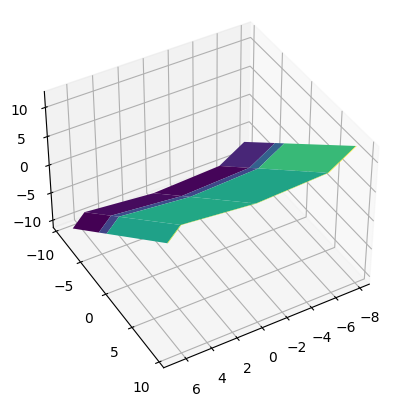

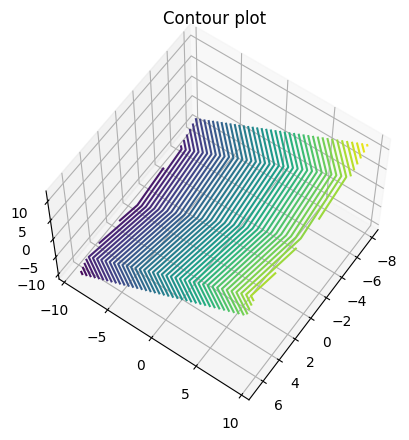

In [142]:
# plot one surface
kf.plot_surface(surfaces[5][0],surfaces[5][1],surfaces[5][2])

## 2. Surface classification 

a $2$-form is given as a layer of a neural network, it has <code> ??? <code> dimensions 


1. precompute the subdivision of a $2$-simplex used for approximating the integral 
2. precompute the tensor that will be used in the computation of the integral 


!!!! Is there a package thaat integrates on trianlges that is compatible with torch?! 


In [143]:
k = 2 
dim = 3 
classes = 2

N = int(scipy.special.binom(dim,k))

kform = nn.Sequential( 
    nn.Linear(dim, N)
) ## can add layers here if needed

kform = nn.Sequential(
    nn.Linear(dim, 10) ## can add layers here if needed
    nn.Linear(10,N)
)

## Mlp layers post integration
mlp = nn.Sequential(
    nn.Linear(1, 20),
    nn.ReLU(),
    nn.Linear(20, 10), ## was 20 before 
    nn.ReLU(),
    nn.Linear(10, classes)
)


In [144]:
## Precomputed things 
num_sub = 2 ## how many times we subdivide each triangle for integration 
subdivision_vert, subdivision_coefs = kf.subdivide_simplex_coef_torch(num_sub)

det = kf.build_determinant_tensor(dim, k) ## will be needed for integration

In [145]:
epochs = 30

# create your optimizer
optimizer = optim.SGD(kform.parameters(), lr=1e-2)

criterion = nn.CrossEntropyLoss()

losses = torch.zeros(epochs)

labels_one_hot_shuffled = labels_one_hot_shuffled.to(torch.float32)

torch.autograd.set_detect_anomaly(True)


Accuracies = []
Losses = []


for e in range(epochs):
    print('epoch: ', e)
    
    correct = 0
    total = 0

    for i in range(len(surfaces_list_shuffled)):
        surface_dict= surfaces_list_shuffled[i]
        l = labels_one_hot_shuffled[i]
        
        X = kf.form2cochain(kform, surface_dict, det, subdivision_vert, subdivision_coefs, num_sub, dim,  k )
        X = torch.reshape(X, (len(surface_dict['simplices']), 1))
        X.retain_grad() 
        X = mlp(X)
        X = X.sum(0)
        X.retain_grad()
        #X.grad = None
        # softmax
        sm = torch.nn.functional.softmax(X)
        #print('softmax = ',sm)
        loss = criterion(sm,l) 
        print("loss: ", loss)
        #print('********')
        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()
        
        pred = torch.argmax(torch.nn.functional.softmax(X))
        #print('pred: ', pred)
        #print('label: ', torch.argmax(l))
        if pred == torch.argmax(l):
            correct += 1
        total += 1
        #print('correct: ', correct)

        if i % 10 == 0:
            print("number of surfaces processed: ", i)

    print('Accuracy of the network on the {} training surfaces at epoch {} : {} '.format(num_surf*2, e, (100 * correct / total)))
    Accuracies.append(100 * correct / total)
    Losses.append(loss) 
    

    print('-----------')
    print('***********')
    print('-----------')


epoch:  0


/Users/celiahacker/opt/anaconda3/envs/celia/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/celiahacker/opt/anaconda3/envs/celia/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


loss:  tensor(0.3137, grad_fn=<DivBackward1>)
number of surfaces processed:  0
loss:  tensor(0.3133, grad_fn=<DivBackward1>)
loss:  tensor(1.2513, grad_fn=<DivBackward1>)
loss:  tensor(0.3133, grad_fn=<DivBackward1>)
loss:  tensor(0.3148, grad_fn=<DivBackward1>)
loss:  tensor(0.3155, grad_fn=<DivBackward1>)
loss:  tensor(1.3086, grad_fn=<DivBackward1>)
loss:  tensor(1.2677, grad_fn=<DivBackward1>)
loss:  tensor(0.3316, grad_fn=<DivBackward1>)
loss:  tensor(0.3144, grad_fn=<DivBackward1>)
loss:  tensor(0.3133, grad_fn=<DivBackward1>)
number of surfaces processed:  10
loss:  tensor(0.3134, grad_fn=<DivBackward1>)
loss:  tensor(0.3176, grad_fn=<DivBackward1>)
loss:  tensor(1.3132, grad_fn=<DivBackward1>)
loss:  tensor(0.3737, grad_fn=<DivBackward1>)
loss:  tensor(0.3133, grad_fn=<DivBackward1>)
loss:  tensor(0.3137, grad_fn=<DivBackward1>)
loss:  tensor(0.3135, grad_fn=<DivBackward1>)
loss:  tensor(0.3136, grad_fn=<DivBackward1>)
loss:  tensor(0.3198, grad_fn=<DivBackward1>)
loss:  tensor

In [147]:
Losses = [loss.detach() for loss in Losses]
with open('kforms/Losses.pkl', 'wb') as f:
    pickle.dump(Losses, f)

# dump accuracies into a pickle file
with open('kforms/Accuracies.pkl', 'wb') as f:
    pickle.dump(Accuracies, f)

# save the model
torch.save(kform.state_dict(), 'kforms/kform_model.pt')
torch.save(mlp.state_dict(), 'kforms/mlp_model.pt')

# save the surfaces
with open('kforms/surfaces.pkl', 'wb') as f:
    pickle.dump(surfaces_list, f)

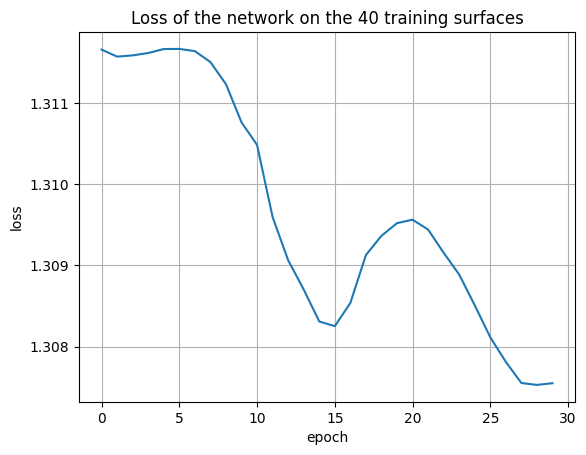

In [148]:
# plot the loss
fig, ax = plt.subplots()
ax.plot(np.arange(len(Losses)), Losses)
ax.set(xlabel='epoch', ylabel='loss', title='Loss of the network on the {} training surfaces'.format(num_surf*2))
ax.grid()
plt.show()



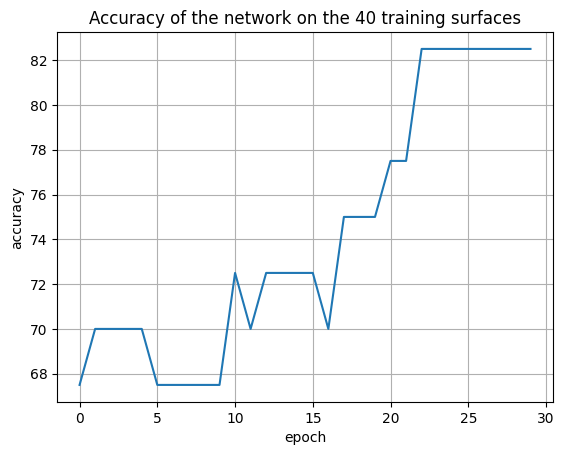

In [149]:
# plot on x axis the epchs and on y axis the accuracy
fig, ax = plt.subplots()
ax.plot(np.arange(len(Accuracies)), Accuracies)
ax.set(xlabel='epoch', ylabel='accuracy', title='Accuracy of the network on the {} training surfaces'.format(num_surf*2))
ax.grid()
plt.show()


## TOdo: 
- are they statistically different? 

# Plots : 

## 1. the cochains in PCA space 

In [150]:
cochains = []
for i in range(len(surfaces_list)):
    surface_dict= surfaces_list[i]
    cochain = kf.form2cochain(kform, surface_dict, det, subdivision_vert, subdivision_coefs, num_sub, dim,  k )
    cochain = cochain.detach().numpy()
    cochains.append(cochain)

# dump cochains into a pickle file
with open('kforms/cochains.pkl', 'wb') as f:
    pickle.dump(cochains, f)

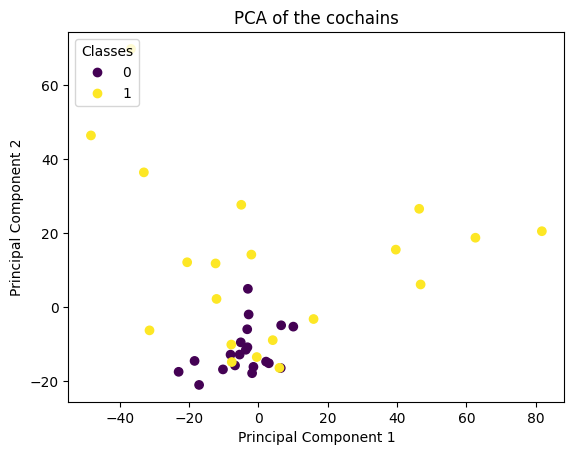

In [151]:
vis.plot_pca_kform(cochains, labels, 2) 

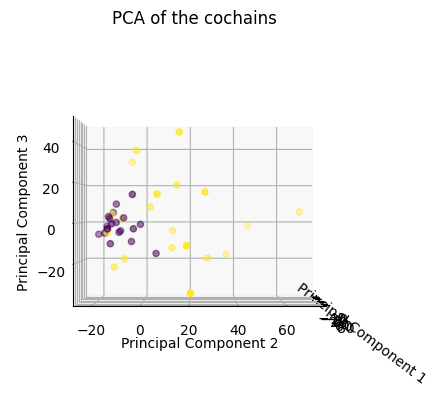

In [159]:

vis.plot_pca_kform(cochains, labels, 3, (0,0))

## 2. norm of cochain on a line 

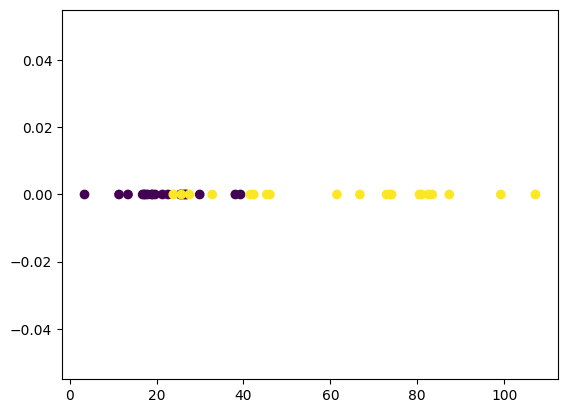

In [166]:
# norm of a vector dist = numpy.linalg.norm(a-b)

Norms = [np.linalg.norm(cochain) for cochain in cochains]

#plot the norms of the cochains
fig, ax = plt.subplots()

ax.scatter(Norms, np.zeros(len(Norms)), c=labels, cmap='viridis')

plt.show()


## 3. The k-form integration value on the surface 

In [160]:
points = kf.unit_square_grid(num_pts)
ac = gd.AlphaComplex(pts).create_simplex_tree()
simplices = [] #list of 2-simplices 

simplices = [] #list of 2-simplices
for s in ac.get_skeleton(2):
    if len(s[0]) == 3: 
        simplices.append(s[0])

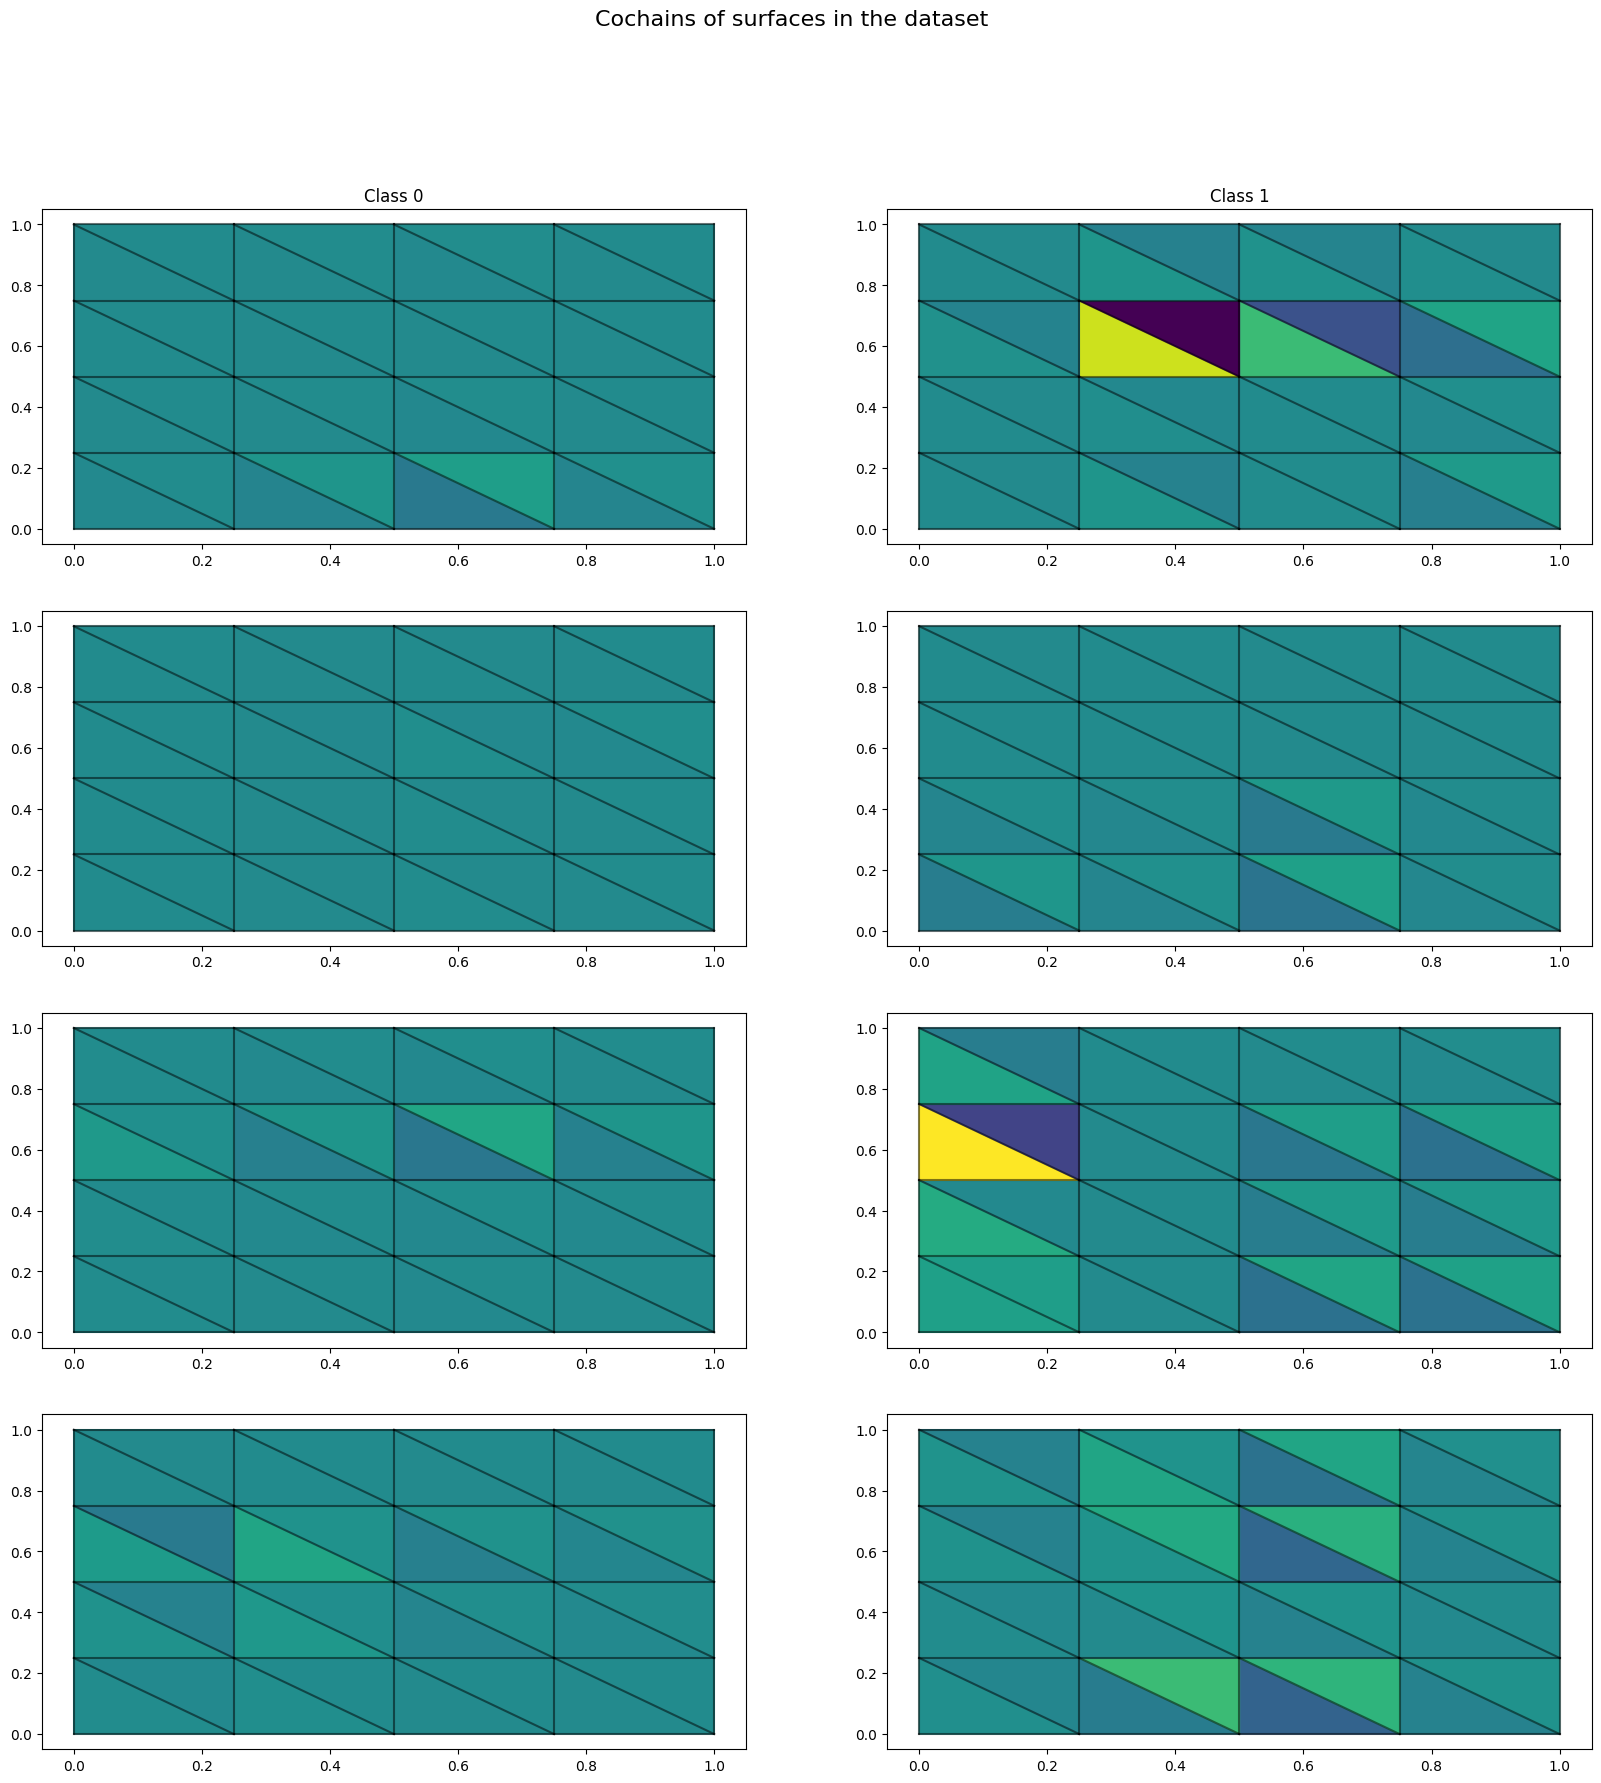

In [161]:
vis.plot_comparison_cochains(cochains, points, simplices, ac, 4)

## Old version 

In [99]:

epochs = 3
dim = 3
num_sub = 3 ## how many times we subdivide each triangle for integration 

# create your optimizer
optimizer = optim.SGD(kform.parameters(), lr=1e-5)

criterion = nn.CrossEntropyLoss()

losses = torch.zeros(epochs)

labels_one_hot_shuffled = labels_one_hot_shuffled.to(torch.float32)

torch.autograd.set_detect_anomaly(True)

for e in range(epochs):
    print('epoch: ', e)
    
    correct = 0
    total = 0

    for i in range(len(surfaces_shuffled)):
        _, _, _, Emb_comp = surfaces_shuffled[i]
        l = labels_one_hot_shuffled[i]
        
        X = kf.form2cochain(kform, Emb_comp, simplices, dim, num_sub, det, k )
        X = torch.reshape(X, (len(simplices), 1))
        X.retain_grad() 
        X = mlp(X)
        X = X.sum(0)
        X.retain_grad()
        #X.grad = None
        # softmax
        sm = torch.nn.functional.softmax(X)
        #print('softmax = ',sm)
        loss = criterion(sm,l) 
        #print("loss: ", loss)
        #print('********')
        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()
        
        pred = torch.argmax(torch.nn.functional.softmax(X))
        #print('pred: ', pred)
        #print('label: ', torch.argmax(l))
        if pred == torch.argmax(l):
            correct += 1
        total += 1
        #print('correct: ', correct)

        if i % 10 == 0:
            print("number of surfaces processed: ", i)

    print('Accuracy of the network on the {} training surfaces at epoch {} : {} '.format(num_surf*3, e, (100 * correct / total)))


    print('-----------')
    print('***********')
    print('-----------')



   
   
   

epoch:  0


IndexError: too many indices for tensor of dimension 2

# graveyard

In [ ]:

def form2cochain(kform, phi, simplices, dim, num_sub): 
    cochain = torch.zeros(len(simplices))
    deter_tensor = build_big_deter_tensor(dim,2) ## maybe this computation can be done outside the function 
    for i in range(len(simplices)):
        simplex = simplices[i]
        phi_simplex = torch.zeros((len(simplex), dim))
        phi_simplex = phi[torch.tensor(simplex)]
        cochain[i] = kf.integral_simplex(kform, phi_simplex, deter_tensor, num_sub)

    return cochain

def form2cochain_output(kform, phi, simplices, dim, num_sub, mlp, classes = 3): 
    output = torch.zeros(len(simplices),classes)
    cochain = torch.zeros(len(simplices),1)
    deter_tensor = kf.build_big_deter_tensor(dim,2) ## maybe this computation can be done outside the function 
    
    for i in range(len(simplices)):
        simplex = simplices[i]
        phi_simplex = torch.zeros((len(simplex), dim))
        phi_simplex = phi[torch.tensor(simplex)]
        cochain[i] = kf.integral_simplex(kform, phi_simplex, deter_tensor, num_sub)

    #output = mlp(cochain)

    return cochain


In [ ]:
def integrate_kform(kform, phi, b, det, subdivision_vert, subdivision_coefs, dim = 3, k = 2):
                    
    """ Integrate a $2$-form over $2$-simplex
    Input: 
        kform: a 2-form
        phi: a matrix containing the embedding of the vertices of the simplex in R^dim
        b: a vector containing the embedding of the basepoint of the simplex in R^dim
        det: the tensor computed by build_determinant_tensor
        dim: the dimension of the embedding space
        k: the dimension of the form
        subdivision_vert: a list of vertices of the subdivision of the simplex
        subdivision_coefs: a list of coefficients for the contribution of each vertex to the integral
        num_sub: the number of subdivisions of the simplex 
    Output:
        integral: the value of integral of the 2-form over the 2-simplex 
    """

    ## TODO: add assert to check inputs are good 

    num_sub = subdivision_vert.shape[0] ## I think num_sub**2 is the number of simplices in the subdivision 
    num_simplices = int(num_sub**2)
    integral = torch.tensor([0]).float()

    N = int(scipy.special.binom(dim,k))

    for i in range(len(subdivision_vert)): ## This is the slow part  
        p = subdivision_vert[i]
        phi_p = phi.T @ p + b
        g_p = torch.tensor([0]).float() 
        for ind in range(N):
            g_p+= kform(phi_p)[ind] * torch.matmul(torch.matmul(phi[0], det[ind]), phi[1].T)
        cof = subdivision_coefs[i]
        integral += torch.mul(g_p,cof)

    vol = torch.tensor([1/(2*(num_sub**2))]).float() ## I'm not sure we need this but double check the theory 
    return (integral* vol )/num_simplices 


def form2cochain(kform, surface_dict, deter_tensor,subivision_vert, subdivision_coeffs, dim =3 ,k = 2): 

    """From a 2-form we get a 2-cochain by integrating the form over every 2-simplex in the simplicial complex
    Input:
        kform: a 2-form
        surface_dict: a dictionary containing all of the information of the triangulated surface in R^dim
        deter_tensor: the tensor computed by build_determinant_tensor
        dim: the dimension of the embedding space
        k: the dimension of the form
        subivision_vert: a list of vertices of the subdivision of the simplex
        subdivision_coefs: a list of coefficients for the contribution of each vertex to the integral
    
    Output:
        cochain: a 2-cochain
     """


    Emb_comp = surface_dict['points']
    assert Emb_comp.shape[1] == dim, "The dimension of the embedding space is not equal to the number of columns of the matrix Emb_comp"

    cochain = torch.zeros(len(surface_dict['simplices']))
    for i in range(len(surface_dict['simplices'])):
     
        phi_simplex = surface_dict['Phi'][i]
        b_simplex = surface_dict['b'][i]
        cochain[i] = integrate_kform(kform, phi_simplex, b_simplex, deter_tensor, subivision_vert, subdivision_coeffs, dim, k)

    return cochain
